# Libraries

In [89]:
import os
import re
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from geohash import decode_exactly as dec_exa_fn,decode as dec_fn
from geopy.distance import great_circle
from pyod.models.iforest import IForest

from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Dense,Dropout,LeakyReLU as lrelu
from tensorflow.keras.initializers import he_normal,constant
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import mae

# Load Data

In [2]:
data = pd.read_csv('../Data/train.csv')

In [3]:
data['start_lat'] = data['geohashed_start_loc'].map(lambda x:dec_exa_fn(x)[0])
data['start_lon'] = data['geohashed_start_loc'].map(lambda x:dec_exa_fn(x)[1])
data['end_lat'] = data['geohashed_end_loc'].map(lambda x:dec_exa_fn(x)[0])
data['end_lon'] = data['geohashed_end_loc'].map(lambda x:dec_exa_fn(x)[1])

data['starttime'] = pd.to_datetime(data['starttime'])

data['distance'] = data.apply(lambda x:great_circle((x['start_lat'],x['start_lon']),
                                                    (x['end_lat'],x['end_lon'])).m,axis = 1)

data.drop(['geohashed_start_loc','geohashed_end_loc'],axis = 1,inplace = True)

In [4]:
data.head()

,orderid,userid,bikeid,biketype,starttime,start_lat,start_lon,end_lat,end_lon,distance
0,1893973,451147,210617,2,2017-05-14 22:16:50,40.103531,116.289597,40.100784,116.286850,384.505061
1,4657992,1061133,465394,1,2017-05-14 22:16:52,39.790421,116.325302,39.797287,116.322556,798.762746
2,2965085,549189,310572,1,2017-05-14 22:16:51,39.882431,116.542282,39.875565,116.551895,1120.640282
3,4548579,489720,456688,1,2017-05-14 22:16:51,39.765701,116.163254,39.765701,116.161880,117.377853
4,3936364,467449,403224,1,2017-05-14 22:16:50,39.963455,116.388474,39.959335,116.381607,743.198674


# EDA

In [5]:
orderID, userID = Counter(data['orderid']), Counter(data['userid'])
bikeID, bikeType = Counter(data['bikeid']), Counter(data['biketype'])

print('# Dataset records: {:d}'.format(len(orderID)))
print('# Dataset users: {:d}, rec/user: {:.2f}'.format(len(userID),len(orderID)/len(userID)))
print('# Dataset bikes: {:d}, rec/bike: {:.2f}'.format(len(bikeID),len(orderID)/len(bikeID)))
print('# Dataset bike types: {:d}'.format(len(bikeType)))
print('# Earliest record: {}, latest record: {}'.format(data['starttime'].min(),
                                                        data['starttime'].max()))

# Dataset records: 3214096
# Dataset users: 349693, rec/user: 9.19
# Dataset bikes: 485465, rec/bike: 6.62
# Dataset bike types: 2
# Earliest record: 2017-05-10 00:00:09, latest record: 2017-05-24 19:00:16


## start-time distribution

In [6]:
time_data = data[['userid','starttime','distance']]
time_data['hour'] = time_data['starttime'].map(lambda x:x.hour)
time_data['cont_time'] = time_data['starttime'].map(lambda x:x.hour * 60 + x.minute)

Text(0, 0.5, 'Frequency')

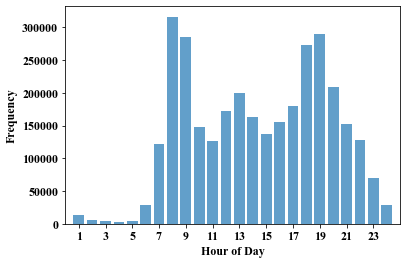

In [7]:
plt.rc('font',family = 'Times New Roman',size = 12)
plt.bar(Counter(time_data['hour']).keys(),Counter(time_data['hour']).values(),alpha = 0.7)
plt.xlim([-1,24])
plt.xticks(np.arange(0,24,2),np.arange(1,25,2))
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')

## 3.2 distance distribution

In [8]:
distanceDict = Counter(
    pd.cut(time_data['distance'],
           [0, 200, 500, 1000, 2000, 3000, 5000, 8000, 10000, 20000, 50000],
           labels=np.arange(0, 10)))
time_data['distance_bins'] = pd.cut(
    time_data['distance'],
    [0, 200, 500, 1000, 2000, 3000, 5000, 8000, 10000, 20000, 50000],
    labels=np.arange(0, 10))

Text(0, 0.5, 'Frequency')

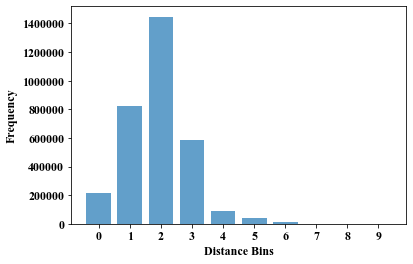

In [9]:
plt.bar(distanceDict.keys(),distanceDict.values(),alpha = 0.7)
xtiks = plt.xticks(np.arange(0,10))
plt.xlabel('Distance Bins')
plt.ylabel('Frequency')

## cross

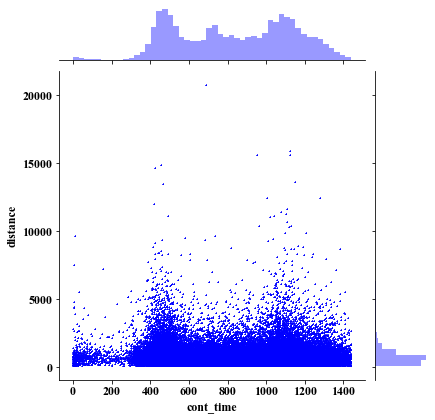

In [19]:
s = np.arange(0,len(time_data),40)
sns.jointplot(time_data['cont_time'][s],
              time_data['distance'][s],
              color='b',
              s=1,marker = '+')

## outlier detection

In [93]:
iforest_detector = IForest(n_estimators=20,
                           max_samples=0.1,
                           contamination=20 / len(time_data),
                           max_features=2,behaviour='new',
                           n_jobs=-1)

In [94]:
idx_state = iforest_detector.fit_predict(time_data[['cont_time','distance']])

In [95]:
time_data[['starttime','distance']].iloc[np.where(idx_state == 1)[0]]

,starttime,distance
699,2017-05-14 22:23:06,25811.113092
100477,2017-05-16 00:45:42,15959.736113
176604,2017-05-10 19:00:23,22448.596039
324553,2017-05-10 18:06:16,26135.888006
479410,2017-05-11 09:59:34,34190.068398
599293,2017-05-11 23:19:40,17690.222269
784758,2017-05-12 18:13:42,23084.398322
856524,2017-05-12 13:03:05,23770.817404
912199,2017-05-12 21:13:23,20470.649136
918643,2017-05-12 20:02:09,24361.869862


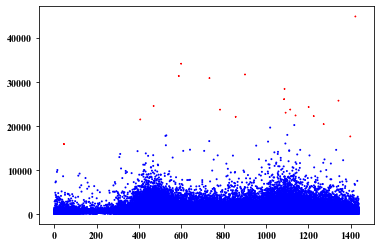

In [96]:
ss = np.where(idx_state == 0)[0]
sss = np.arange(0,len(ss),10)
s = ss[sss]
s1 = np.where(idx_state == 1)[0]
plt.scatter(time_data['cont_time'][s],
            time_data['distance'][s],
            s=1,
            c='',
            edgecolors='b')
plt.scatter(time_data['cont_time'][s1],
            time_data['distance'][s1],
            s=1,
            c='',
            marker = '*',
            edgecolors='r')

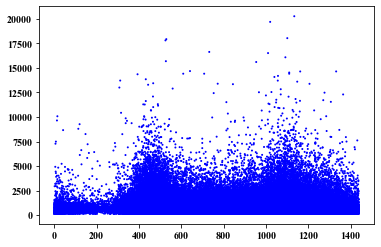

In [97]:
plt.scatter(time_data['cont_time'][s],
            time_data['distance'][s],
            s=1,
            c='',
            edgecolors='b')